# Hidden markov model (HMM)

The goal is to use to find looped and unlooped states in the data from single particle tracking of dual colors.

We will use Gaussian model for emission. 
Given all the data we fit the all the parameters (gaussian parameters, transition probability between looped/unlooped).

[//]: <> (Once we have the model, we use the model to predict the states on the datasets.)

[//]: <> (As control, we could use the TetO dual color control line -looped state and dual color in dCTCF and +auxin -unlooped state-)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from hmmlearn import hmm
from matplotlib.backends.backend_pdf import PdfPages
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

### Dual color imaging

To estimate the transition probability, we should have data without gaps. However we have gaps from time to time . To cope with this, we filled gaps using the distance of the first previous frame with no missing value. We allow maximum 20\% of tracks to be with missing values

In [3]:
fraction_nan_max = 0.2 # maximum fraction of gaps allowed 
reproducible = True
rolling = 0
if reproducible:
    np.random.seed(47)

From the experimental data we got an resolution limit of 100 +/- 50nm on distance. We will set the minimum diagonal of covariance matrix (error on the estimates) to be equal to 100nm (0.1).

### Model training

In [4]:
basedir = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines/"
name = "two_colors_distance_30s"
acquisition = 30
dataset = f"{basedir}/211129_{name}.csv.zip"

# list_cell_lines = ["1B1", "1A2"]
list_cell_lines = ["1B1"]


data = pd.read_csv(dataset)
data = data[data.cell_line.isin(list_cell_lines)]
data = data[data.induction_time == "0min"]

exp_means = data.groupby("condition").mean()['distance']
exp_std = data.groupby("condition").std()['distance']

original = pd.DataFrame()
length = []
for _, sub in data.groupby("uniqueid"):
    sub, c = fill_gaps(sub, "frame")
    
    if c / len(sub) < fraction_nan_max:
        if rolling > 1:
            sub.distance = sub.distance.rolling(rolling, center=True).mean()
            sub.dropna(inplace=True)
        original = pd.concat([original, sub])
        length.append(len(sub))

print(f"Average datapoints across trajectories {np.mean(length)}")
data = original.copy()


traj = data["distance"].values
# hmm needs as input (obs, nfeatures)
traj2d = np.reshape((traj), (-1, 1))
lengths = data.uniqueid.value_counts()[data.uniqueid.unique()].values
print(f"\n Number of data points used in the model {traj2d.shape}")

# initiate model

nstates = 2
model = hmm.GaussianHMM(
    n_components=nstates,
    covariance_type="full",
    min_covar=0.1,
    n_iter=10000,
    params="mtc",
    init_params="mtc",
)

# instead of fitting
model.startprob_ = [1/nstates] * nstates
model.fit(traj2d)
# model.fit(traj2d, lengths=lengths)

means = model.means_
covars = model.covars_
sigmas = np.sqrt(model.covars_.squeeze())
w = np.array(model.transmat_)
logProb = model.score(traj2d)
print(f"\n Gaussian means: {means} \n ------")
print(f"Gaussian std: {sigmas} \n ------")
print(f"Transition rates: {w} \n ------")
print(f"logProg = {logProb} \n ------")
print(f"Starting probability = {model.startprob_} \n ------")

with open(f"{basedir}/hmmmodel_{name}.obj", "wb") as file_model:
    pickle.dump(model, file_model)

Average datapoints across trajectories 252.52083333333334

 Number of data points used in the model (12121, 1)

 Gaussian means: [[0.1493922 ]
 [0.28807371]] 
 ------
Gaussian std: [0.0612939  0.13342964] 
 ------
Transition rates: [[0.95274362 0.04725638]
 [0.1461874  0.8538126 ]] 
 ------
logProg = 12888.998913083984 
 ------
Starting probability = [0.5 0.5] 
 ------


# Predict on samples and check the distribution of distances of the two states across samples

### Predict on 1B1 0 min

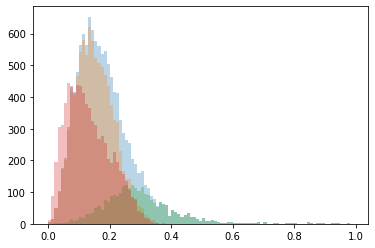

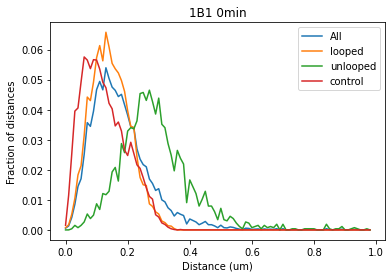

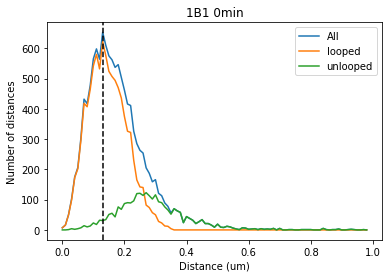

In [5]:
pdf = PdfPages(f"{basedir}/hmm_gaussian_parameters_{acquisition}s.pdf")


res = pd.DataFrame()
for _, sub in data.groupby('uniqueid'):
    tmp = sub.copy()
    distance = sub.distance.values.reshape(-1, 1)
    states = (model.predict(distance))
    tmp['states'] = states
    res = pd.concat([tmp, res])
res["states_numeric"] = res.states.values
res.states.replace(0, "looped", inplace=True)
res.states.replace(1, "unlooped", inplace=True)
res["condition"] = res["cell_line"] + "_" + res["induction_time"]


res_limit = pd.read_csv("/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines/control_lines_new/alldatapooled.csv")
res_limit = res_limit[res_limit.dist_cutoff == 0.3].copy()
res_limit.dropna(inplace=True)
hists = []

density=False
hist = plt.hist(res.distance, bins = np.arange(0, 1, 0.01), alpha = 0.3, density = density)
hists.append(hist)

hist=plt.hist(res.distance[res.states == "looped"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = density)
hists.append(hist)

hist=plt.hist(res.distance[res.states == "unlooped"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = density)
hists.append(hist)

hist = plt.hist(res_limit.distance_after, bins = np.arange(0, 1, 0.01), alpha = 0.3, density = density)
hists.append(hist)

fig = plt.figure()
for hist in hists:
    plt.plot( hist[1][:-1], hist[0]/ np.sum(hist[0]))
plt.legend(["All", "looped", "unlooped", "control"])
plt.title("1B1 0min")
plt.xlabel("Distance (um)")
plt.ylabel("Fraction of distances")
pdf.savefig(fig)


fig = plt.figure()
for hist in hists[:-1]:
    plt.plot( hist[1][:-1], hist[0])
plt.legend(["All", "looped", "unlooped"])
plt.axvline(res_limit.distance_after.mean(), color='black', ls='--', label="Control line mean")
plt.title("1B1 0min")
plt.xlabel("Distance (um)")
plt.ylabel("Number of distances")
pdf.savefig(fig)



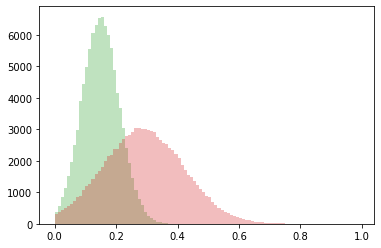

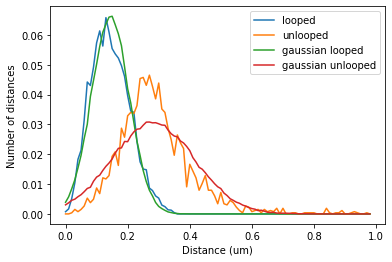

In [6]:
# how good are looped and unlooped state approx in terms of gaussian?
g1 = np.random.normal(0.1493922, .0612939, 100000)
g2 = np.random.normal(0.28807371, .13342964, 100000)

hists = []
hist=plt.hist(res.distance[res.states == "looped"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

hist=plt.hist(res.distance[res.states == "unlooped"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

hist=plt.hist(g1, bins = np.arange(0, 1, 0.01), alpha = 0.3)
hists.append(hist)

hist=plt.hist(g2, bins = np.arange(0, 1, 0.01), alpha = 0.3)
hists.append(hist)


fig = plt.figure()
for hist in hists:
    plt.plot(hist[1][:-1], hist[0]/ np.sum(hist[0]))
plt.legend(["looped", "unlooped", "gaussian looped", "gaussian unlooped"])
plt.xlabel("Distance (um)")
plt.ylabel("Number of distances")
pdf.savefig(fig)

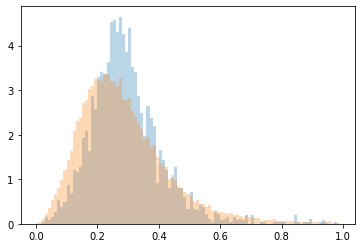

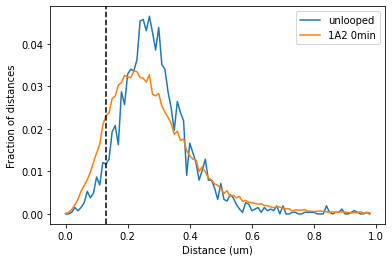

In [7]:
list_cell_lines = ["1A2"]

data = pd.read_csv(dataset)
data = data[data.cell_line.isin(list_cell_lines)]
data = data[data.induction_time == "0min"]

fig = plt.figure()
hists = []

hist = plt.hist(res.distance[res.states == "unlooped"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

hist = plt.hist(data.distance, bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

fig = plt.figure()
for hist in hists:
    plt.plot( hist[1][:-1], hist[0]/np.sum(hist[0]))

plt.axvline(res_limit.distance_after.mean(), color='black', ls='--', label="Control line mean")
plt.legend(["unlooped", "1A2 0min"])
plt.ylabel("Fraction of distances")
plt.xlabel("Distance (um)")
pdf.savefig(fig)

### What is the difference between 1A2/1B1 120min and unlooped state?


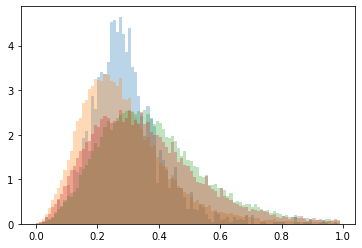

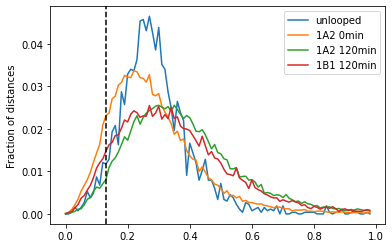

In [8]:
list_cell_lines = ["1A2", "1B1"]

data = pd.read_csv(dataset)
data = data[data.cell_line.isin(list_cell_lines)]
data['condition'] = data['cell_line'] + "_" + data['induction_time']

exp_means = data.groupby("condition").mean()['distance']
exp_std = data.groupby("condition").std()['distance']

fig = plt.figure()
hists = []

hist = plt.hist(res.distance[res.states == "unlooped"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

hist= plt.hist(data.distance[data['condition'] == "1A2_0min"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

hist=plt.hist(data.distance[data['condition'] == "1A2_120min"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

hist=plt.hist(data.distance[data['condition'] == "1B1_120min"], bins = np.arange(0, 1, 0.01), alpha = 0.3, density = True)
hists.append(hist)

fig = plt.figure()
for hist in hists:
    plt.plot( hist[1][:-1], hist[0]/np.sum(hist[0]))

plt.legend(["unlooped", "1A2 0min", "1A2 120min", "1B1 120min"])
plt.axvline(res_limit.distance_after.mean(), color='black', ls='--', label="Control line mean")
plt.ylabel("Fraction of distances")
pdf.savefig(fig)

### what are the contact duration and second passage time?

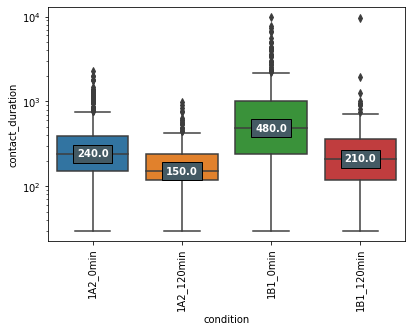

In [10]:
from utils import *
list_cell_lines = ["1A2", "1B1"]

data = pd.read_csv(dataset)
data = data[data.cell_line.isin(list_cell_lines)]
data["condition"] = data["cell_line"] + "_" + data["induction_time"]

hue_order = sorted(data["condition"].unique())
(
    original_durations,
    original_second_passage_times,
    _,
    fraction_time,
    conditions,
    data_filtered_original,
) = calculate_duration_second_passage_time(
    data=data,
    resolution=30,
    model=model,
    fraction_nan_max=0.2,
)

# Contact duration
fig = plt.figure()
box_plot = sns.boxplot(
    data=original_durations, x="condition", y="contact_duration", hue_order=hue_order
)

ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    y = round(lines[4 + cat * 6].get_ydata()[0], 1)

    ax.text(
        cat,
        y,
        f"{y}",
        ha="center",
        va="center",
        fontweight="bold",
        size=10,
        color="white",
        bbox=dict(facecolor="#445A64"),
    )

box_plot.figure.tight_layout()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.yscale('log')
plt.show()
pdf.savefig(box_plot.figure)

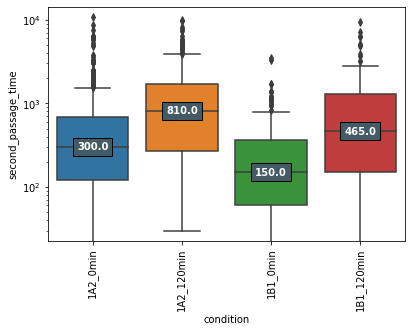

In [11]:
# Contact duration
fig = plt.figure()
box_plot = sns.boxplot(
    data=original_second_passage_times, x="condition", y="second_passage_time", hue_order=hue_order
)

ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    y = round(lines[4 + cat * 6].get_ydata()[0], 1)

    ax.text(
        cat,
        y,
        f"{y}",
        ha="center",
        va="center",
        fontweight="bold",
        size=10,
        color="white",
        bbox=dict(facecolor="#445A64"),
    )

box_plot.figure.tight_layout()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.yscale('log')
plt.show()
pdf.savefig(box_plot.figure)

### What are the gaussian mean and standard deviation of the fitted model?

In [12]:
df = pd.DataFrame(model.means_, columns=["Gaussian_means"])
df["Gaussian_std"] = sigmas
df["imaging_type"] = "30s"
df["state"] = ["looped", "unlooped"]

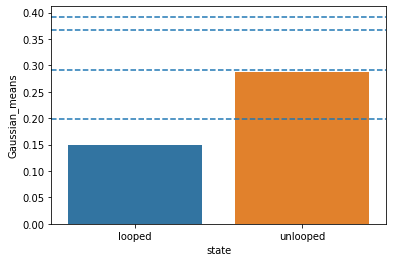

In [13]:
fig = sns.barplot(data = df, y="Gaussian_means", x="state")
for value in exp_means:
    plt.axhline(y=value, linestyle='--')
pdf.savefig(fig.figure)

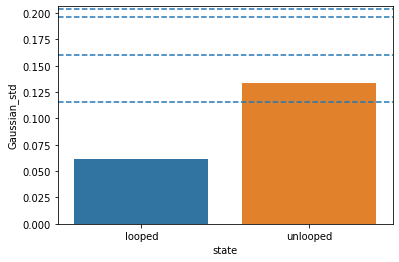

In [14]:
fig = sns.barplot(data = df, y="Gaussian_std", x="state")
for value in exp_std:
    plt.axhline(y=value, linestyle='--')
pdf.savefig(fig.figure)

In [15]:
pdf.close()